In [1]:
# ! pip install tqdm yfinance quantstats

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import yfinance as yf
import pandas as pd

start = '2006-01-01'
end = '2024-01-01'

symbol = 'AAPL'

data = yf.download(symbol, start, end)
benchmark = data['Close']

[*********************100%%**********************]  1 of 1 completed


In [4]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03,2.585000,2.669643,2.580357,2.669643,2.263002,807234400
2006-01-04,2.683214,2.713571,2.660714,2.677500,2.269662,619603600
2006-01-05,2.672500,2.675000,2.633929,2.656429,2.251801,449422400
2006-01-06,2.687500,2.739286,2.662500,2.725000,2.309926,704457600
2006-01-09,2.740357,2.757143,2.705000,2.716071,2.302359,675040800
...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.600006,37122800
2023-12-26,193.610001,193.889999,192.830002,193.050003,193.050003,28919300
2023-12-27,192.490005,193.500000,191.089996,193.149994,193.149994,48087700


In [5]:
from btester import Strategy

def UpBreakout(ser: pd.Series, period: int):
    return (ser.rolling(period).max().diff() > 0).values

def DownBreakout(ser: pd.Series, period: int):
    return (ser.rolling(period).min().diff() < 0).values

class BreakoutStrategy(Strategy):
    def init(self, buy_period: int, sell_period: int):
        self.buy_signal = UpBreakout(self.data['Close'], buy_period)
        self.sell_signal = DownBreakout(self.data['Close'], sell_period)

    def next(self, i, record):
        if self.buy_signal[i-1]:
            self.open(price=record['Open'])

        if self.sell_signal[i-1]:
            self.close(price=record['Open'])

In [6]:
from btester import Backtest
backtest = Backtest(BreakoutStrategy, data, commission=.001, cash=1e6)

In [7]:
import quantstats as qs
from itertools import product
from tqdm.contrib.concurrent import process_map

parameters = ['Buy period','Sell period']
values = [[5, 10, 20, 50, 75, 100, 150, 200], [5, 10, 20, 50, 75, 100, 150, 200]]

def run(v):
    result = backtest.run(*v)
    returns = result.returns
    return [*v, returns.iloc[0], returns.iloc[-1], qs.stats.max_drawdown(returns) * 100, qs.stats.cagr(returns) * 100, qs.stats.sharpe(returns)]

optimization_results = process_map(run, list(product(*values)))
optimization_results = pd.DataFrame(optimization_results, columns=[*parameters,'Initial Capital','Cumulative Return','Max Drawdown (%)','CAGR (%)','Sharpe Ratio'])
optimization_results.set_index([*parameters], inplace=True)

100%|██████████| 64/64 [00:03<00:00, 18.34it/s]


In [8]:
optimization_results_sorted = optimization_results.sort_values('Sharpe Ratio', ascending=False)
optimization_results_sorted

,,Initial Capital,Cumulative Return,Max Drawdown (%),CAGR (%),Sharpe Ratio
Buy period,Sell period,,,,,
100,75,1000000.0,5.784462e+07,-30.405845,16.843333,1.102270
150,75,1000000.0,3.989181e+07,-36.591328,15.189557,1.030636
75,75,1000000.0,4.761179e+07,-40.874912,15.973961,1.015744
10,20,1000000.0,3.947630e+07,-49.830806,15.143298,1.011185
100,100,1000000.0,4.437432e+07,-35.929618,15.661088,1.008587
...,...,...,...,...,...,...
75,10,1000000.0,5.004342e+06,-22.519268,6.372252,0.689733
150,5,1000000.0,3.271799e+06,-26.153082,4.652172,0.629626
100,10,1000000.0,3.852968e+06,-28.325020,5.310648,0.605212


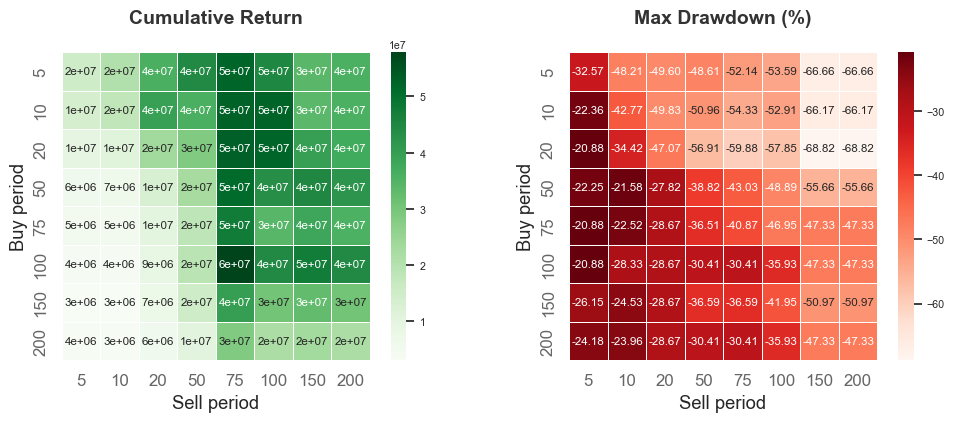

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].set_title('Cumulative Return\n', fontsize=14, fontweight='bold')
ax[1].set_title('Max Drawdown (%)\n', fontsize=14, fontweight='bold')

reshape = lambda d: pd.DataFrame(d.values.reshape(len(d.index.levels[0]), len(d.index.levels[1])), d.index.levels[0], d.index.levels[1])

sns.set(font_scale=.7)
sns.heatmap(reshape(optimization_results['Cumulative Return']), ax=ax[0], annot=True, fmt='.0g', linewidth=.5, square=True, cmap='Greens')
sns.heatmap(reshape(optimization_results['Max Drawdown (%)']), ax=ax[1], annot=True, fmt='.2f', linewidth=.5, square=True, cmap='Reds')

plt.show()

In [10]:
best_params = optimization_results_sorted.index[0]
best_params

(100, 75)

In [11]:
result = backtest.run(*best_params)

In [12]:
import quantstats as qs
qs.reports.metrics(result.returns, benchmark)

                    Benchmark     Strategy
------------------  ------------  ------------------------
Start Period        2006-01-03    2006-01-03
End Period          2023-12-29    2023-12-29
Risk-Free Rate      0.0%          0.0%
Time in Market      100.0%        100.0%

Cumulative Return   7,111.83%     -
CAGR﹪              17.84%        16.84%

Sharpe              0.9           1.1
Prob. Sharpe Ratio  99.99%        100.0%
Sortino             1.32          1.66
Sortino/√2          0.94          1.17
Omega               1.27          1.27

Max Drawdown        -60.87%       -
Longest DD Days     718           6494

Gain/Pain Ratio     0.18          0.27
Gain/Pain (1M)      1.0           1.69

Payoff Ratio        1.11          1.1
Profit Factor       1.18          -
Common Sense Ratio  1.25          1.43
CPC Index           0.69          0.75
Tail Ratio          1.07          50.25
Outlier Win Ratio   2155300797.5  1.65
Outlier Loss Ratio  -36227646.48  -

MTD                 1.36%     

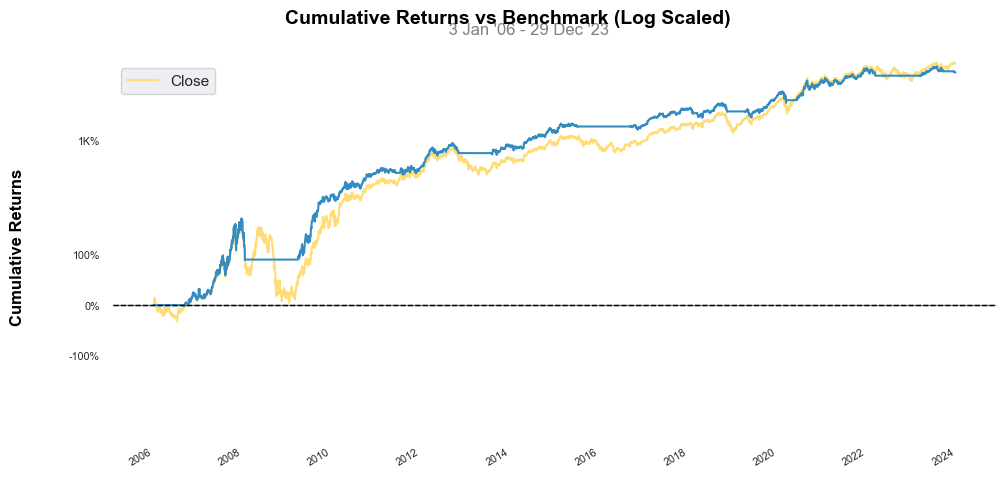

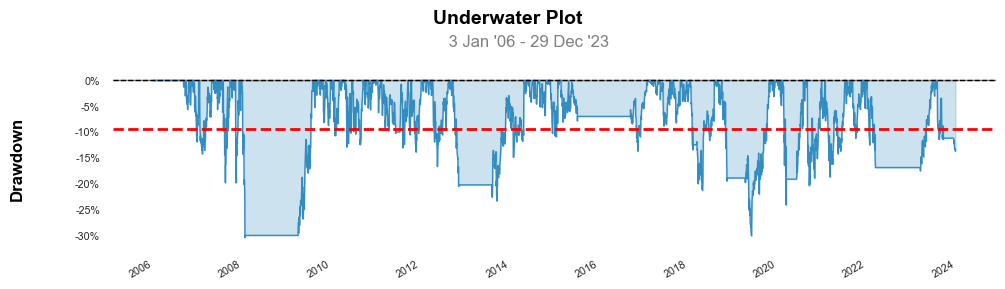

In [13]:
qs.plots.log_returns(result.returns, benchmark=benchmark)
qs.plots.drawdown(result.returns, figsize=(10,3))

In [14]:
trades = pd.DataFrame(result.trades)
trades.tail(15)

,symbol,open_date,close_date,open_price,close_price,position_size,profit_loss,change_pct,trade_commission,cumulative_return
0,None,2006-09-08,2008-01-24,2.620357,4.999643,381246.137473,9.070935e+05,90.800062,2905.095524,1.904188e+06
1,None,2009-04-03,2011-06-13,4.078214,11.685714,466450.771251,3.548524e+06,186.539973,7353.096344,5.445359e+06
2,None,2011-07-18,2012-11-08,13.051071,20.022499,416817.853525,2.905816e+06,53.416519,13785.654561,8.337389e+06
3,None,2013-08-06,2015-07-09,16.715000,30.962500,498298.547364,7.099508e+06,85.237806,23757.628878,1.541314e+07
4,None,2016-09-15,2018-02-09,28.465000,39.267502,540935.963087,5.843462e+06,37.950120,36638.946193,2.121996e+07
5,None,2018-03-12,2018-11-15,45.072498,47.097500,470325.913640,9.524107e+05,4.492765,43349.938599,2.212902e+07
6,None,2019-04-11,2020-03-13,50.212502,66.222504,440267.182134,7.048679e+06,31.884494,51262.511636,2.912644e+07
7,None,2020-06-08,2022-03-14,82.562500,151.449997,352428.065332,2.427789e+07,83.436787,82472.571563,5.332185e+07
8,None,2023-03-17,2023-09-22,156.080002,174.669998,341290.267677,6.344585e+06,11.910556,112881.756034,5.955356e+07


In [15]:
open_positions = pd.DataFrame(result.open_positions)
open_positions

,symbol,open_date,last_date,open_price,last_price,position_size,profit_loss,change_pct,current_value
0,None,2023-12-14,2023-12-29,198.020004,192.529999,300444.712216,-1.649443e+06,-2.77245,5.784462e+07
